# Analysing memory usage

In [1]:
from components.model import get_income_and_attitude_weights
import sys
from pympler.asizeof import asizeof


incomes, weights = get_income_and_attitude_weights(700, 0.6)

print(sys.getsizeof(incomes),sys.getsizeof(weights))
asizeof(incomes),asizeof(weights) 
# (5728, 41368) 13.03.24
# (2928, 24568) after np.float32


2912 8544


(2928, 24568)

In [2]:
from data.canada import uncertain_demand_from_income_and_province, get_end_use_agg_heating_share


demand = uncertain_demand_from_income_and_province(incomes, "Ontario")
agg_heat_share = get_end_use_agg_heating_share("Ontario", 2000)
print(sys.getsizeof(demand),sys.getsizeof(agg_heat_share))
asizeof(demand),asizeof(agg_heat_share)
# (5728, 48)

2912 32


(2928, 48)

In [3]:
from components.technologies import merge_heating_techs_with_share
import pandas as pd

heat_tech_shares = merge_heating_techs_with_share(2000, "Ontario")
print(sys.getsizeof(heat_tech_shares))
# heat_tech_shares[:] = np.float16(heat_tech_shares.values)

asizeof(heat_tech_shares.astype("float16"))

948


25720

In [4]:
from components.model import TechnologyAdoptionModel

model = TechnologyAdoptionModel(500, "Ontario", ts_step_length="w")
print(sys.getsizeof(model))
asizeof(model) 
# holy smokes! 963243912 13.03.24
# 693435952 after some float32 conversions
#  35754928 after resampling to "w" ~ 19x less memory
#  25546080 with 500 instead of 700 agents

/mnt/speicher/.wissmit/david/.conda/envs/cando/lib/python3.10/site-packages/mesa/time.py:79: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


48


25806864

In [5]:
fuel_demands = model.schedule.agents[0].potential_fuel_demands
asizeof(fuel_demands),asizeof(fuel_demands.astype("int32"))

(18032, 18032)

In [7]:
from components.probability import beta_with_mode_at
from components.technologies import Technologies

dist_params = dict(zip(Technologies,[0.5]*len(Technologies)))

atts = model.draw_attitudes_from_distribution(beta_with_mode_at, dist_params)
print(sys.getsizeof(atts))
asizeof(atts)
# 74640

10144


37040

# The parameter fit

In [8]:
import pandas as pd

from components.model import TechnologyAdoptionModel
from components.technologies import Technologies
from components.probability import beta_with_mode_at
from data.canada import nrcan_tech_shares_df

from batch import BatchResult

historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
tech_mode_map = dict(zip(Technologies, [0.5] * len(Technologies)))

province = "Ontario"
gut = 0.33
p_mode = 0.33

h_tech_shares = historic_tech_shares.loc[province, :] / 100
att_mode_table = h_tech_shares.copy()


# Analysing parameter fit results

In [1]:
import pandas as pd
import plotly.express as px
from pathlib import Path
# results_dir = "results/fitting/2024.02.26-14.39"
# results_dir = "results/fitting/2024.03.12-16.03"
# results_dir = "results/fitting/2024.03.13-16.19"
results_dir = "results/fitting/2024.04.05-14.52"

def file_in_dir_like(dir, name_frag, suffix=".csv"):
    matches = list(Path(results_dir).glob(f"*{name_frag}*{suffix}"))
    if len(matches) != 1:
        raise ValueError(f"found {matches}, proceeding not defined")
    return matches[0]
att_mode_table = pd.read_csv(file_in_dir_like(results_dir,"all_attitude_modes"))

att_mode_table[["p_mode","gut"]] = att_mode_table[["p_mode","gut"]].round(2)

att_mode_table.head()

/tmp/ipykernel_4150282/3455353951.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  att_mode_table = pd.read_csv(file_in_dir_like(results_dir,"all_attitude_modes"))


Unnamed: 0  year  iteration  gut  p_mode          variable     value
0           0  2000          0  0.2     0.2  Electric furnace  0.157905
1           1  2001          0  0.2     0.2  Electric furnace  0.161564
2           2  2002          0  0.2     0.2  Electric furnace  0.171355
3           3  2003          0  0.2     0.2  Electric furnace   0.18192
4           4  2004          0  0.2     0.2  Electric furnace   0.19384

In [2]:
best_modes = pd.read_csv(file_in_dir_like(results_dir, "best_modes"))
best_modes.head()

year  Electric furnace  Gas furnace  Heat pump  Oil furnace  \
0  2000          0.148463     0.690924   0.056998     0.096521   
1  2001          0.168398     0.624812   0.112588     0.079775   
2  2002          0.214592     0.548601   0.171473     0.050000   
3  2003          0.259667     0.443891   0.212470     0.050000   
4  2004          0.308802     0.332042   0.258803     0.058038   

   Wood or wood pellets furnace  best_abs_diff province  gut  p_mode  
0                      0.050040       0.902586  Ontario  0.2     0.2  
1                      0.053151       0.902586  Ontario  0.2     0.2  
2                      0.060346       0.902586  Ontario  0.2     0.2  
3                      0.072425       0.902586  Ontario  0.2     0.2  
4                      0.071517       0.902586  Ontario  0.2     0.2

In [3]:

best_modes[["p_mode","gut"]] = best_modes[["p_mode","gut"]].round(2)
best_modes[["best_abs_diff", "province", "gut", "p_mode",]].groupby(["province","gut","p_mode"]).mean().reset_index().pivot(index=["province","gut"], columns="p_mode", values="best_abs_diff")

p_mode             0.20      0.25      0.30      0.35      0.40      0.45  \
province gut                                                                
Ontario  0.20  0.902586  0.722058  1.025573  0.897088  0.862288  0.749599   
         0.25  0.735735  0.806158  0.677616  0.545248  0.497274  0.513422   
         0.30  0.577901  0.701429  0.655315  0.481681  0.543437  1.024234   
         0.35  0.614481  0.405116  0.537683  1.016525  1.456441  1.995325   
         0.40  0.606991  0.993488  1.170209  1.763641  2.710841  3.024125   
         0.45  1.659053  1.815888  2.124609  2.764441  2.876441  3.377725   
         0.50  1.200971  2.029488  2.675009  3.039641  3.332441  3.488125   
         0.55  2.039053  3.128653  3.059809  3.042841  3.580441  3.752125   
         0.60  2.903053  3.410253  3.234209  3.594041  3.746041  3.888125   
         0.65  2.866253  3.495853  3.571009  3.696441  3.914041  3.958525   
         0.70  3.190253  3.566253  3.616609  3.718841  3.858841  3.962525   
         0.75  3.269453  4.163853  3.391712  3.612441  3.870041  3.962525   
         0.80  4.145453  4.163853  3.704609  3.624441  3.916441  3.915325   

p_mode             0.50      0.55      0.60      0.65      0.70      0.75  \
province gut                                                                
Ontario  0.20  0.672118  0.446051  0.454903  1.039590  1.362267  1.940833   
         0.25  0.517356  1.020828  2.104390  2.096390  2.729467  2.875233   
         0.30  1.481514  2.123872  2.596994  2.928994  3.019067  3.592833   
         0.35  2.580714  2.754272  3.352390  3.401990  3.367867  3.823233   
         0.40  3.081514  3.445472  3.529190  3.637190  3.599397  3.912033   
         0.45  3.485710  3.761472  3.749990  3.824390  3.658267  3.940033   
         0.50  3.802314  3.842272  3.823590  3.850790  3.679067  3.978433   
         0.55  3.944110  3.901472  3.869990  3.864390  3.708667  3.980033   
         0.60  4.012110  3.933472  3.891590  3.881990  3.713467  3.992033   
         0.65  4.017710  3.970272  3.914790  3.917190  3.731867  4.015233   
         0.70  4.032910  4.009472  3.946790  3.938790  3.756667  4.054433   
         0.75  4.052110  4.014272  3.995590  3.995590  3.815067  4.060833   
         0.80  4.053710  4.017472  3.995590  3.995590  3.815067  4.060833   

p_mode             0.80  
province gut             
Ontario  0.20  2.324910  
         0.25  3.333710  
         0.30  3.661710  
         0.35  3.924110  
         0.40  4.042237  
         0.45  4.046237  
         0.50  4.043310  
         0.55  4.048110  
         0.60  4.058510  
         0.65  4.076910  
         0.70  4.124910  
         0.75  4.161710  
         0.80  4.165710

In [4]:
top_12 = best_modes.groupby(["gut","p_mode"])[["best_abs_diff"]].min().sort_values(by="best_abs_diff").reset_index().loc[:4,:]
top_12

gut  p_mode  best_abs_diff
0  0.35    0.25       0.405116
1  0.20    0.55       0.446051
2  0.20    0.60       0.454903
3  0.30    0.35       0.481681
4  0.25    0.40       0.497274

In [5]:
top_p_modes = top_12['p_mode'].to_list()
top_guts = top_12['gut'].to_list()
asc_p_mode = sorted(top_12["p_mode"].unique())
asc_gut = sorted(top_12["gut"].unique())
top_gut_p_modes = list(zip(top_guts, top_p_modes))

In [6]:
att_mode_table["gut and p_mode"] = att_mode_table[["gut","p_mode"]].values.tolist()
att_mode_table["gut and p_mode"] = att_mode_table["gut and p_mode"].apply(tuple)
att_mode_table.head()

Unnamed: 0  year  iteration  gut  p_mode          variable     value  \
0           0  2000          0  0.2     0.2  Electric furnace  0.157905   
1           1  2001          0  0.2     0.2  Electric furnace  0.161564   
2           2  2002          0  0.2     0.2  Electric furnace  0.171355   
3           3  2003          0  0.2     0.2  Electric furnace   0.18192   
4           4  2004          0  0.2     0.2  Electric furnace   0.19384   

  gut and p_mode  
0     (0.2, 0.2)  
1     (0.2, 0.2)  
2     (0.2, 0.2)  
3     (0.2, 0.2)  
4     (0.2, 0.2)

In [7]:

atts = att_mode_table.query(f"variable!='province'").set_index(["gut and p_mode","year"]).loc[top_gut_p_modes,:,:].reset_index()
atts["value"] = atts["value"].astype(float)
fig = px.line(atts, x="year", y="value", color="variable", facet_col="p_mode", facet_row="gut", line_dash="iteration", template="plotly", height=700, category_orders={"p_mode":asc_p_mode, "gut":asc_gut})
fig.update_traces(opacity=.2, )
fig.update_layout(yaxis_title="Mode")
fig.write_html(f"{results_dir}/fitted_att_modes.html")
fig

In [8]:
best_modes["gut and p_mode"] = best_modes[["gut","p_mode"]].values.tolist()
best_modes["gut and p_mode"] = best_modes["gut and p_mode"].apply(tuple)

best_modes_long = best_modes.melt(id_vars=["year","province","p_mode","gut","best_abs_diff","gut and p_mode"]).set_index(["gut and p_mode","year"]).loc[top_gut_p_modes,:,:].reset_index()
fig = px.line(best_modes_long, x="year", y="value", color="variable", facet_col="p_mode", facet_row="gut", template="plotly", category_orders={"p_mode":asc_p_mode, "gut":asc_gut}, height=700)
fig.update_layout(yaxis_title="Mode")
fig.write_html(f"{results_dir}/fitted_att_modes_best_only.html")
fig


In [9]:
tech_shares = pd.read_csv(file_in_dir_like(results_dir, "historic_tech"), index_col=0)
tech_shares[["gut","p_mode"]] = tech_shares[["gut","p_mode"]].round(2)
tech_shares["gut and p_mode"] = tech_shares[["gut","p_mode"]].values.tolist()
tech_shares["gut and p_mode"] = tech_shares["gut and p_mode"].apply(tuple)
tech_shares = tech_shares.set_index(["gut and p_mode","year"]).loc[top_gut_p_modes,:,:].reset_index()
tech_shares.head()

gut and p_mode     year province  iteration          variable   value   gut  \
0   (0.35, 0.25)  2000.00  Ontario          0  Electric furnace  0.1620  0.35   
1   (0.35, 0.25)  2000.25  Ontario          0  Electric furnace  0.1616  0.35   
2   (0.35, 0.25)  2000.50  Ontario          0  Electric furnace  0.1592  0.35   
3   (0.35, 0.25)  2000.75  Ontario          0  Electric furnace  0.1592  0.35   
4   (0.35, 0.25)  2001.00  Ontario          0  Electric furnace  0.1564  0.35   

   p_mode  
0    0.25  
1    0.25  
2    0.25  
3    0.25  
4    0.25

In [10]:
import numpy as np
contains_val = ~top_12.pivot(columns="p_mode",index="gut").isna().values
indcs = list(zip(*np.where(contains_val==True)))
indcs

[(0, 3), (0, 4), (1, 2), (2, 1), (3, 0)]

In [11]:
from data.canada import nrcan_tech_shares_df

fig = px.line(tech_shares, x="year", y="value", color="variable", facet_col="p_mode", facet_row="gut", line_dash="iteration", template="plotly", category_orders={"p_mode":asc_p_mode, "gut":asc_gut}, height=700)
fig.for_each_trace(lambda t: t.update(showlegend=False))

fig.update_traces(opacity=0.2)

province="Ontario"
historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
h_tech_shares = historic_tech_shares.loc[province, :] / 100

h_tech_shares_long = h_tech_shares.melt(ignore_index=False)

hist_fig = px.line(h_tech_shares_long.reset_index(), x="year", y="value", color="variable", template="plotly")


legend_names = []
for idx in indcs:
    for trace in hist_fig.data:
        if trace.name in legend_names:
            showlegend = False
        else: 
            showlegend = True
            legend_names.append(trace.name)
        trace.showlegend = showlegend
        fig.add_trace(trace, row=np.array(indcs).max(axis=0)[0]+1-idx[0], col=idx[1]+1)
fig.update_layout(yaxis_title="Adoption Levels")
fig.write_html(f"{results_dir}/fitted_adoption_levels.html")
fig

In [12]:
import seaborn as sns
future_shares = pd.read_csv(file_in_dir_like(results_dir, "future"), index_col=0)
future_shares[["gut","p_mode"]] = future_shares[["gut","p_mode"]].round(2)
future_shares["gut and p_mode"] = future_shares[["gut","p_mode"]].values.tolist()
future_shares["gut and p_mode"] = future_shares["gut and p_mode"].apply(tuple)
future_shares = future_shares.set_index(["gut and p_mode","year"]).loc[top_gut_p_modes,:,:].melt(ignore_index=False, id_vars=["RunId","province","p_mode","gut"]).reset_index()


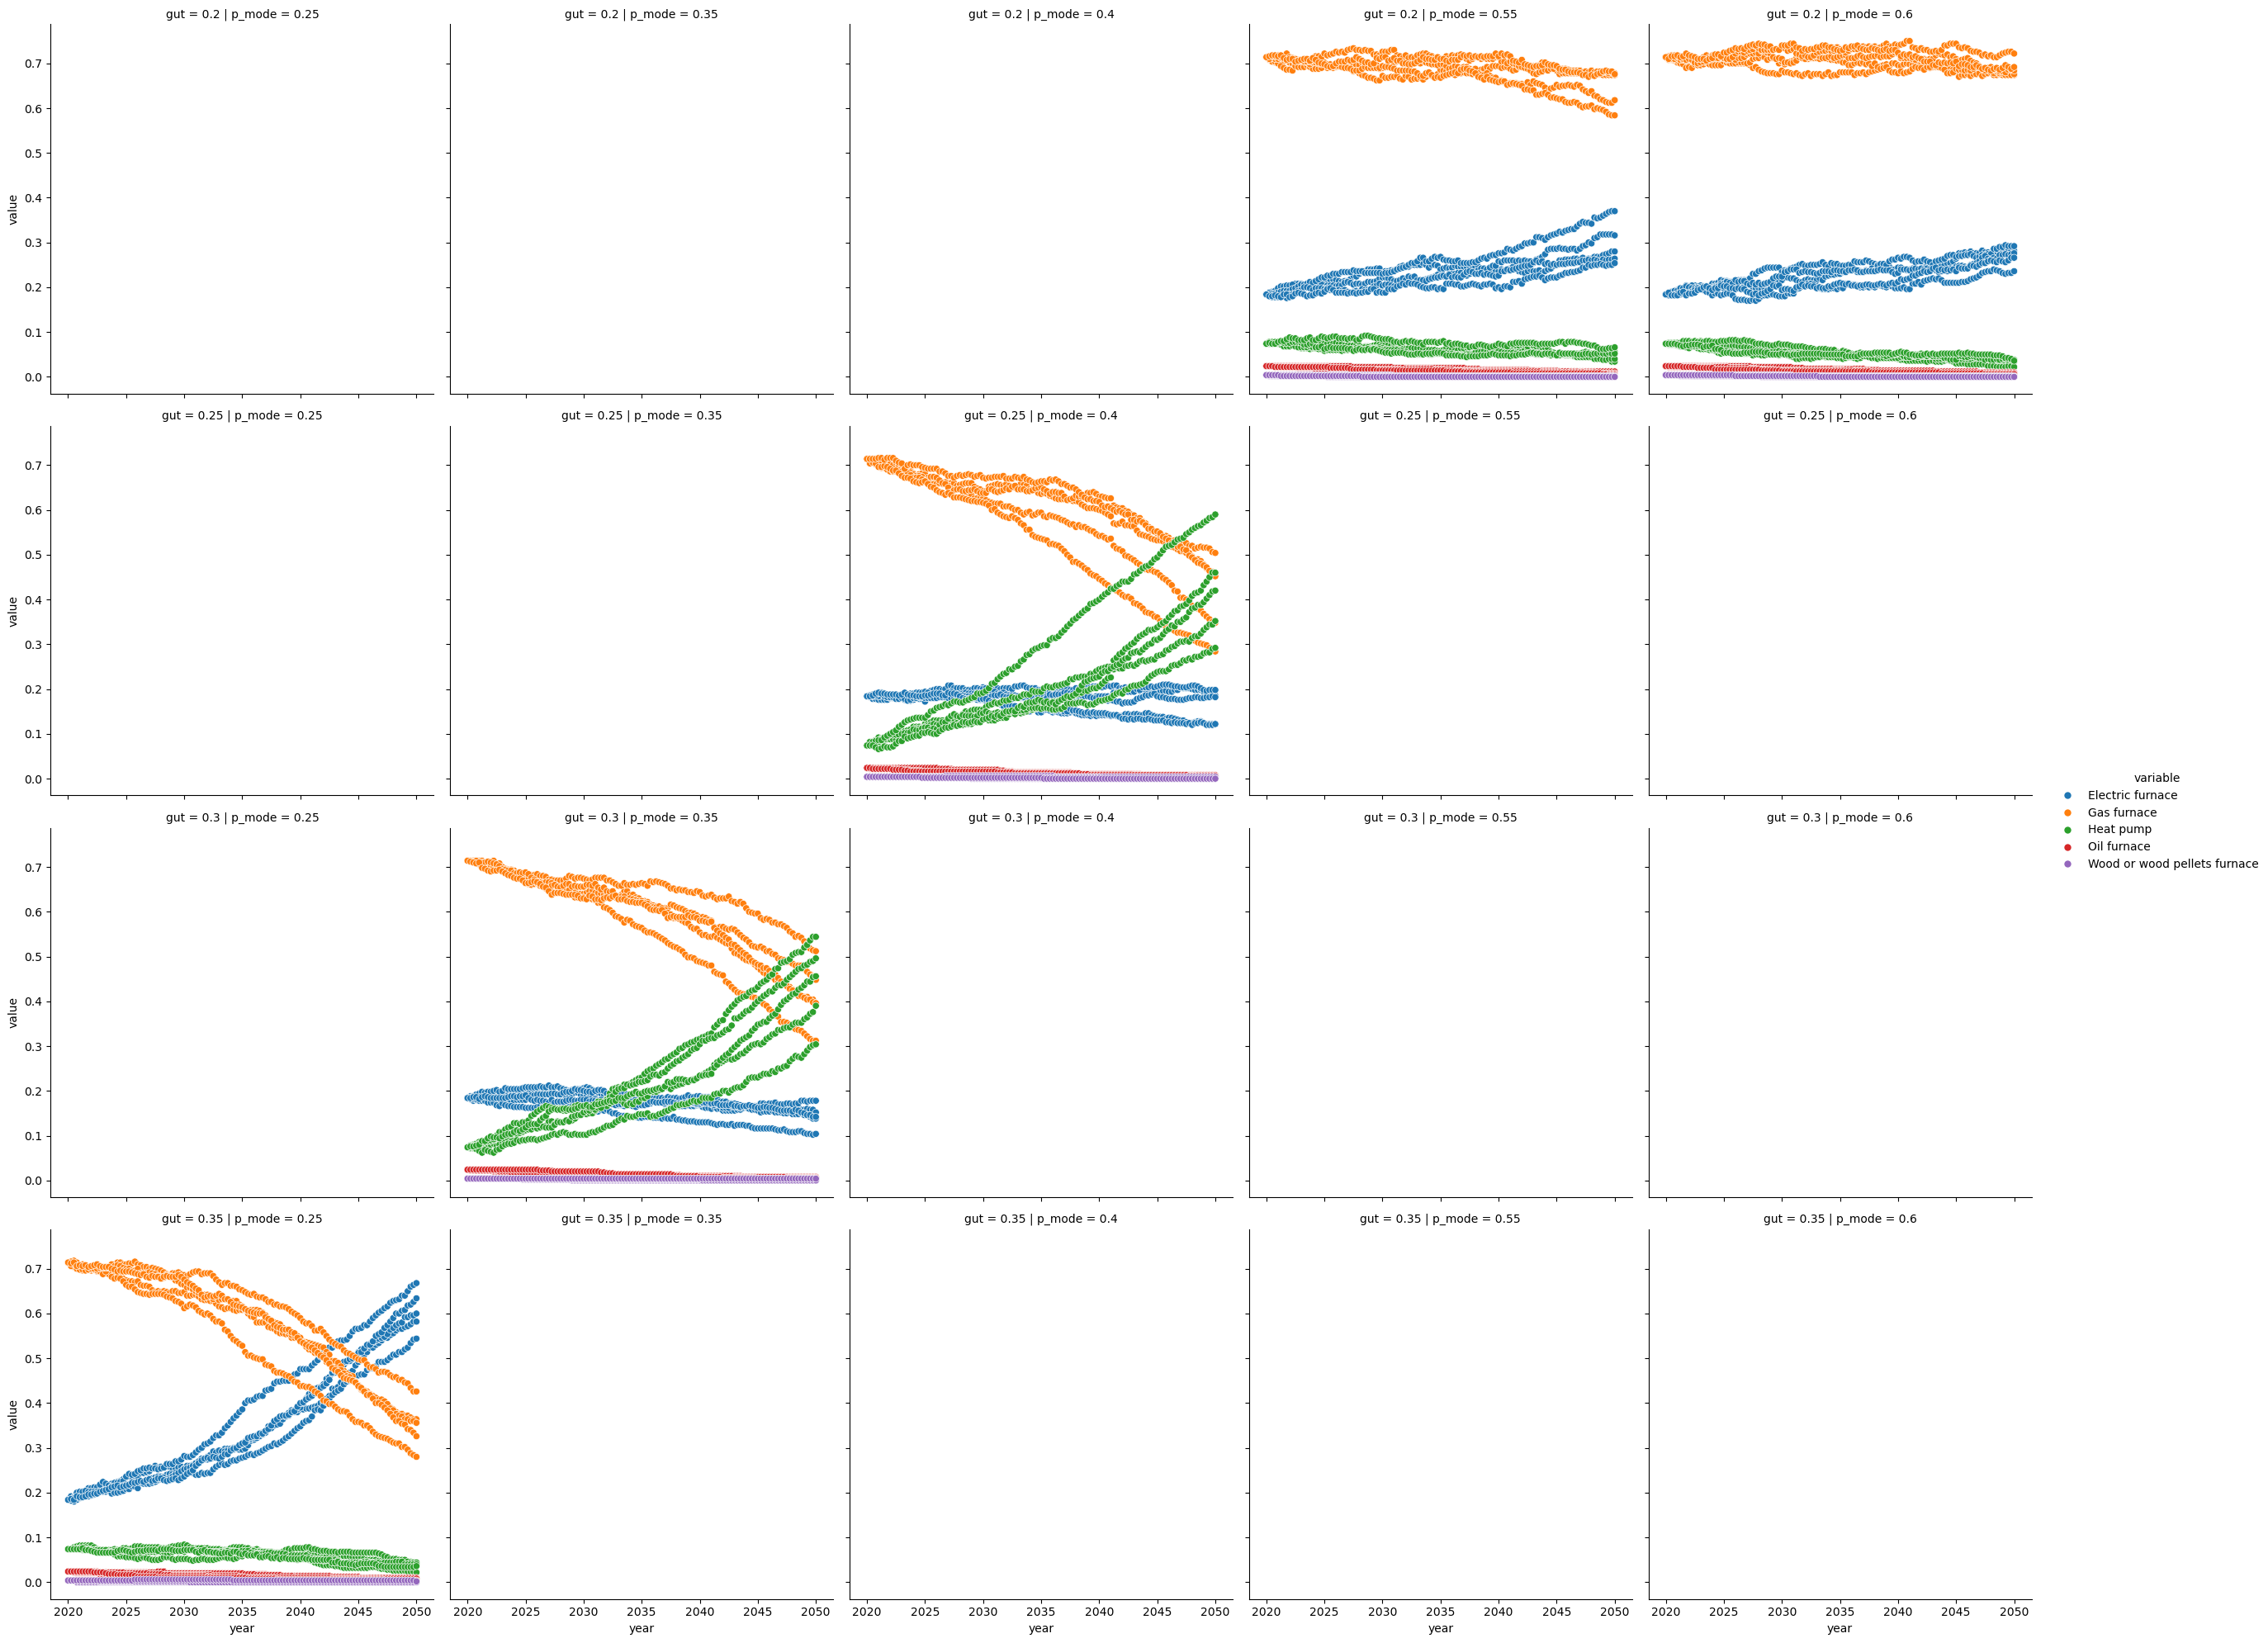

In [13]:
ax = sns.relplot(future_shares, x="year", y="value", hue="variable", col="p_mode",row="gut")
ax.figure.savefig(f"{results_dir}/fitted_future_adoptions.png")

# Overlay batch run with historic adoption

In [14]:
top_12

gut  p_mode  best_abs_diff
0  0.35    0.25       0.405116
1  0.20    0.55       0.446051
2  0.20    0.60       0.454903
3  0.30    0.35       0.481681
4  0.25    0.40       0.497274

In [15]:
# pick params, and form att_mode_table
position = 0
gut = top_12['gut'][0]
p_mode = top_12['p_mode'][0]
att_mode_table = best_modes.query(f"gut=={gut} and p_mode=={p_mode}").iloc[:,:-5].set_index("year")
att_mode_table.head()

Electric furnace  Gas furnace  Heat pump  Oil furnace  \
year                                                          
2000          0.130448     0.681507   0.070351     0.110523   
2001          0.211595     0.481342   0.220317     0.065364   
2002          0.292090     0.369347   0.338970     0.050000   
2003          0.424169     0.077044   0.448434     0.050000   
2004          0.519310     0.050000   0.485822     0.050000   

      Wood or wood pellets furnace  
year                                
2000                      0.050118  
2001                      0.059163  
2002                      0.074159  
2003                      0.099558  
2004                      0.095698

In [16]:
from batch import BatchResult

result = BatchResult.from_parameters(
        batch_parameters = {
        "N": [150],
        "province": [province],
        "random_seed": range(20, 25),
        "start_year": 2000,
        "tech_att_mode_table": [att_mode_table],
        "n_segregation_steps": [60],
        "interact": [False],
        "global_util_thresh": [gut],
        "price_weight_mode": [p_mode],
        "ts_step_length":["w"]
    }
)

results_dir=PosixPath('/mnt/speicher/.wissmit/david/canadopt/abetam/results/feature_time_aggregation/8156b69216aabf8295316b8f29561325') does not exist. Running model.


  0%|          | 0/5 [00:00<?, ?it/s]

/mnt/speicher/.wissmit/david/.conda/envs/cando/lib/python3.10/site-packages/mesa/time.py:79: FutureWarning:

The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919

/mnt/speicher/.wissmit/david/.conda/envs/cando/lib/python3.10/site-packages/mesa/time.py:79: FutureWarning:

The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919

/mnt/speicher/.wissmit/david/.conda/envs/cando/lib/python3.10/site-packages/mesa/time.py:79: FutureWarning:

The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch 

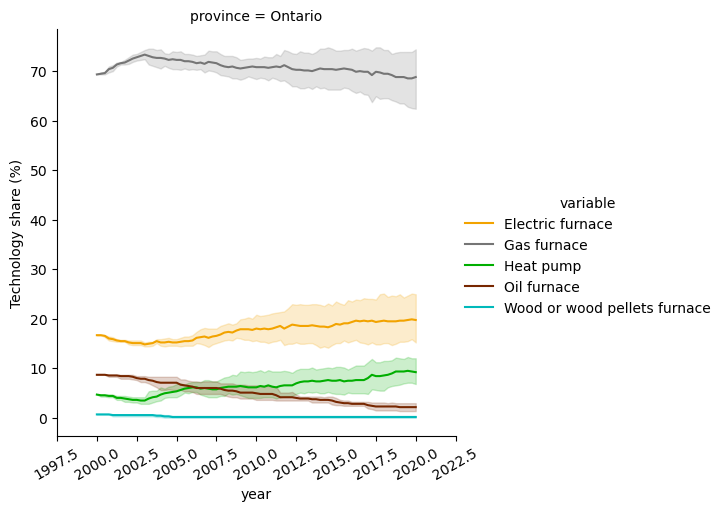

In [17]:
ax = result.tech_shares_fig()
added_historic_traces = False
# ax

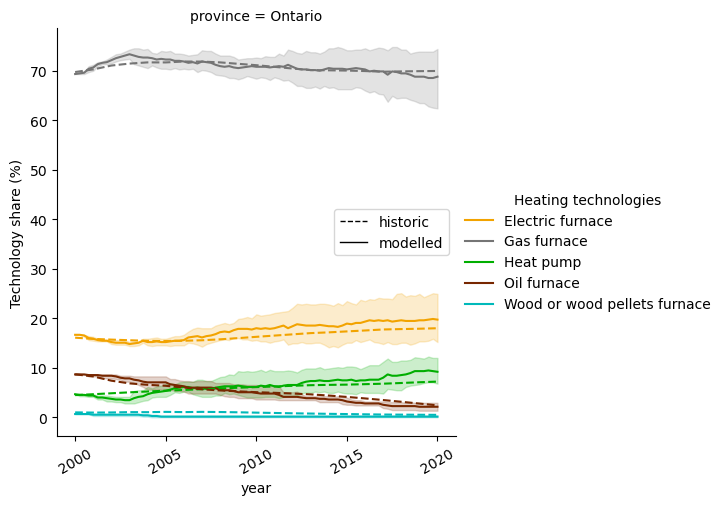

In [18]:
from data.canada import nrcan_tech_shares_df
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import config

historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
if not added_historic_traces:
    for tech in historic_tech_shares.columns:
        y = historic_tech_shares.loc[province, tech]
        added_historic_traces = True
        ax.ax.plot(y.index,y.values, "--", color=config.TECHNOLOGY_COLORS[tech],)

new_title = 'Heating technologies'
ax._legend.set_title(new_title)


custom_lines = [Line2D([0], [0], linestyle="--", color="black", lw=1),
                Line2D([0], [0], color="black", lw=1),
                ]
ax.ax.legend(custom_lines, ['historic', 'modelled'],)
ax.ax.set_xticks(range(2000,2021,5), labels=range(2000,2021,5))
ax.ax.figure.savefig(f"{results_dir}/fitted_vs_historic_adoption.svg")
ax.ax.figure


In [19]:
leg = ax.ax.get_legend()
ax.add_legend(leg, title="Heating technologies", loc=(0.5, 0.5))
ax.ax.figure


AttributeError: 'Legend' object has no attribute 'keys'